<a href="https://colab.research.google.com/github/QuynhNgoc59/Churned-users-prediction/blob/main/Churned_users_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/[Stats & ML] Final project/churn_prediction.csv")

**1. Data Preprocessing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

**1.1 Check imbalanced data**

In [ ]:
#Check imbalanced data
imb_df = df.groupby('Churn')['CustomerID'].count().reset_index()
imb_df['%'] = imb_df['CustomerID']/ sum(imb_df['CustomerID'])
imb_df

,Churn,CustomerID,%
0,0,4682,0.831616
1,1,948,0.168384


**=> The imbalance rate is 16.84% -> acceptable for processing ML model**

**1.2 Handle missing values**

In [ ]:
print(df.isna().sum().sort_values())

CustomerID                       0
Complain                         0
NumberOfAddress                  0
MaritalStatus                    0
SatisfactionScore                0
PreferedOrderCat                 0
Gender                           0
NumberOfDeviceRegistered         0
CityTier                         0
PreferredLoginDevice             0
Churn                            0
PreferredPaymentMode             0
CashbackAmount                   0
WarehouseToHome                251
HourSpendOnApp                 255
CouponUsed                     256
OrderCount                     258
Tenure                         264
OrderAmountHikeFromlastYear    265
DaySinceLastOrder              307
dtype: int64


<Axes: >

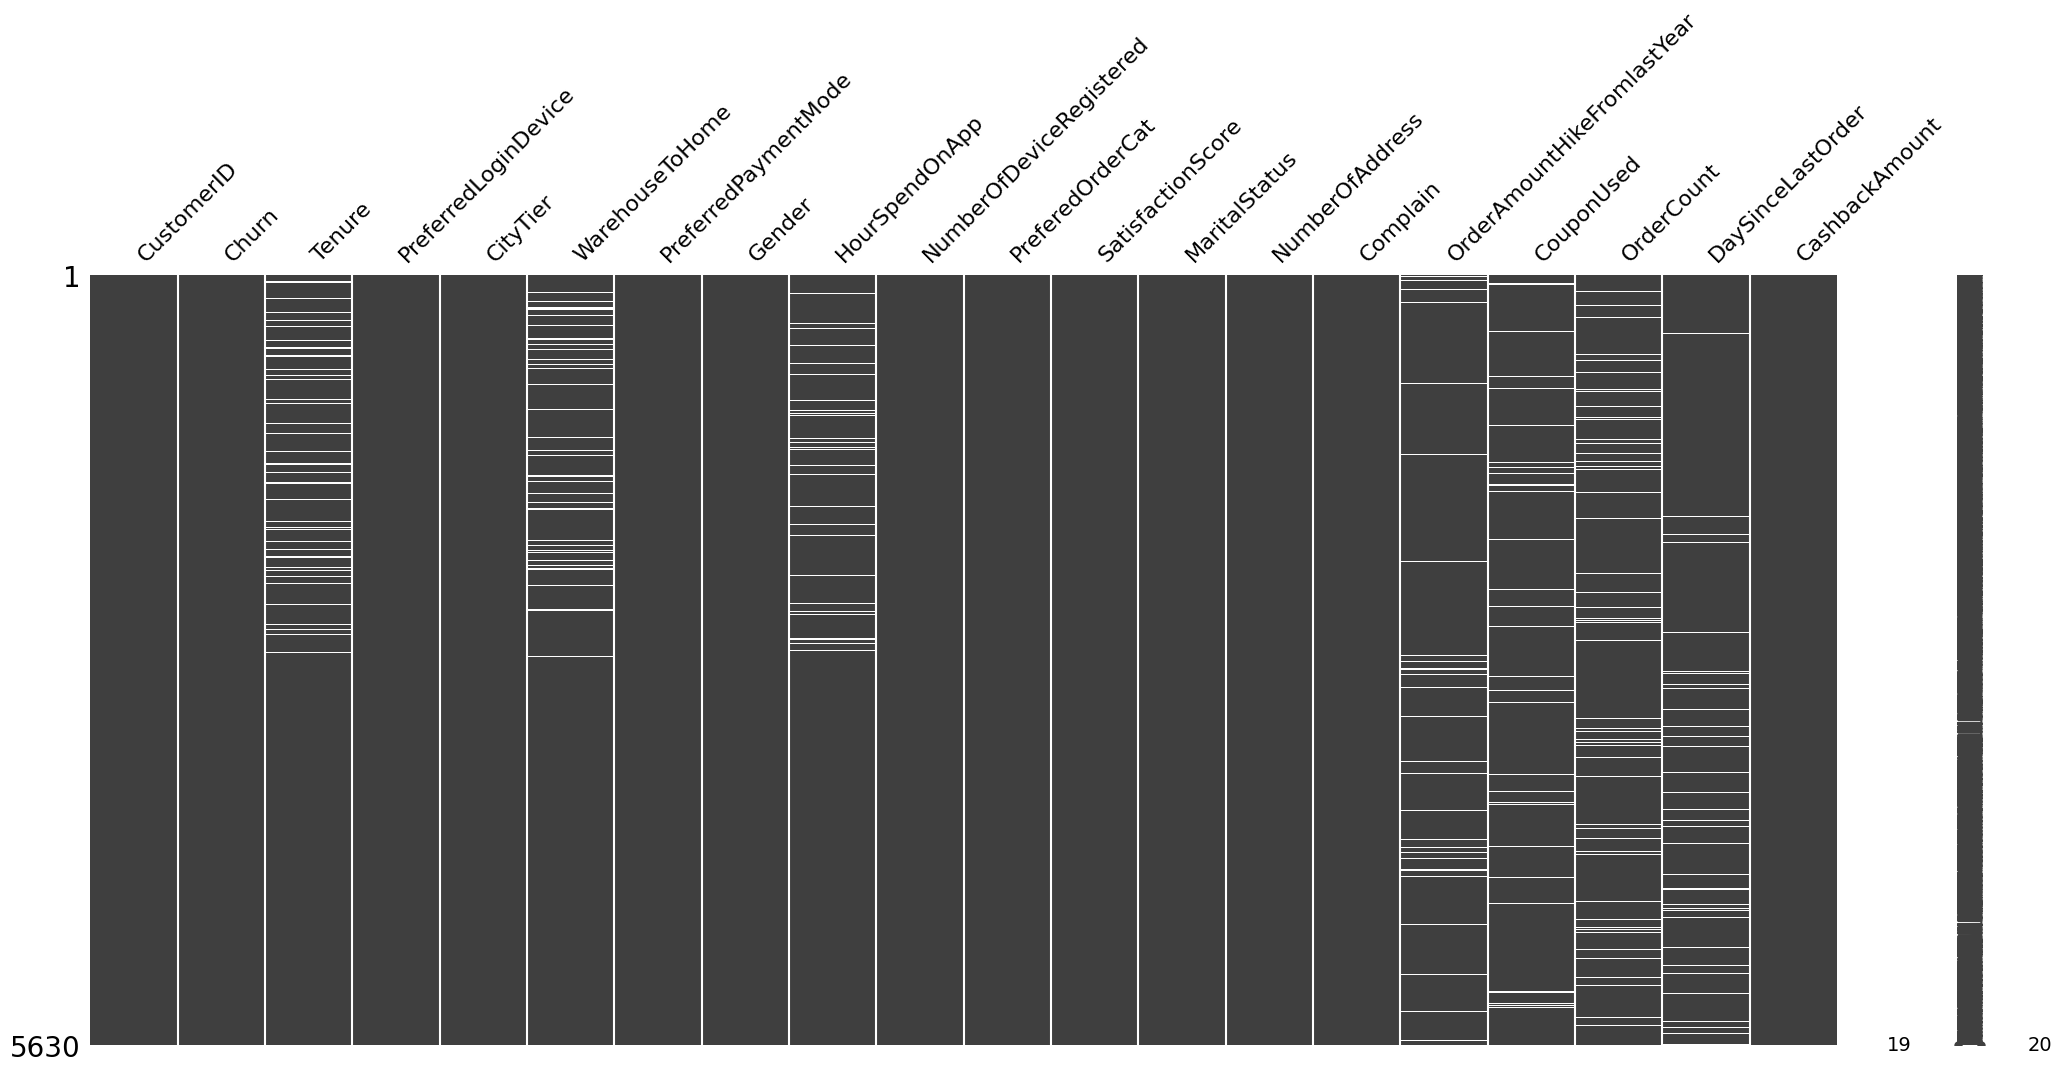

In [ ]:
import missingno as msno
msno.matrix(df)

In [ ]:
#Check data type of the columns containing missing values
list_null = df.columns[df.isnull().any().tolist()]
df[list_null].dtypes

Tenure                         float64
WarehouseToHome                float64
HourSpendOnApp                 float64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
dtype: object

**=> The missing values are more than 5% of 5630 data rows -> Cannot be deleted -> Need to be replaced by other values:**

**(1) Columns with numeric values:**
   + In case there are ouliers: replace with the mean
   + In case there is no outlier: replace with the median

**(2) Columns with category values: replace missing values with the mode**

**(3) Columns containing 0: replace missing values with 0**

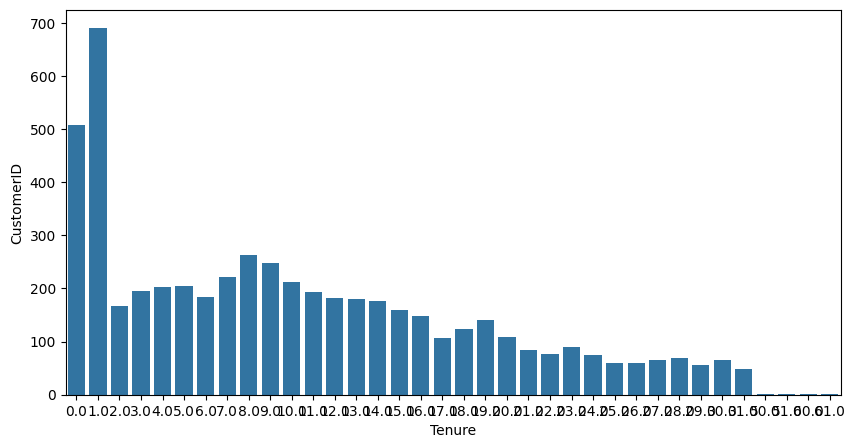

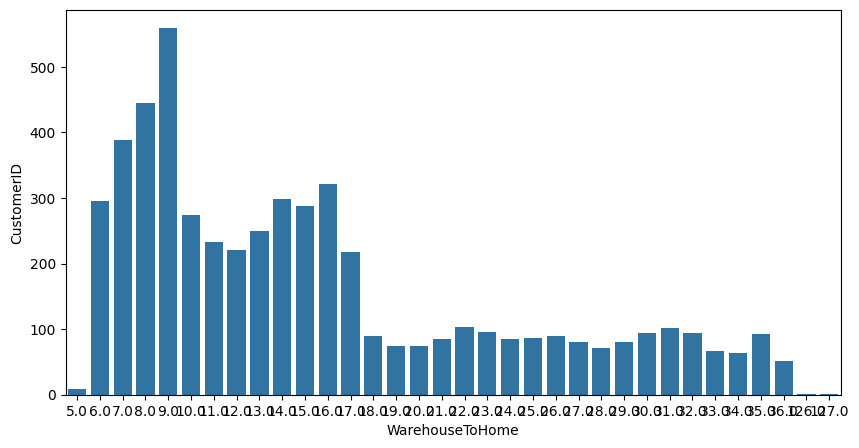

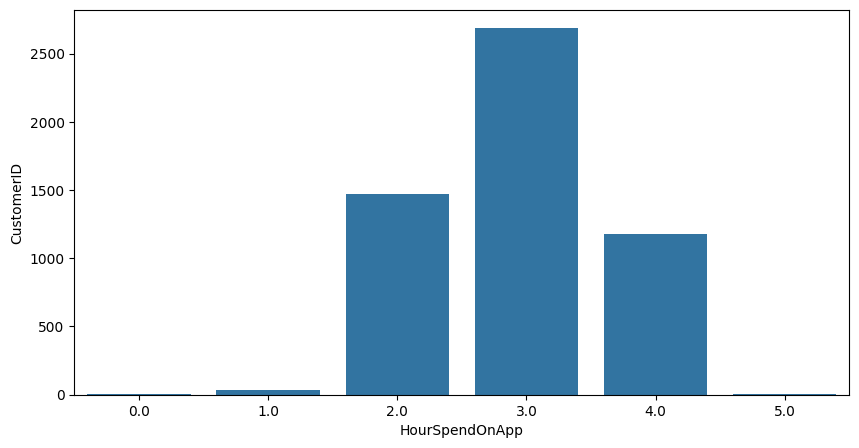

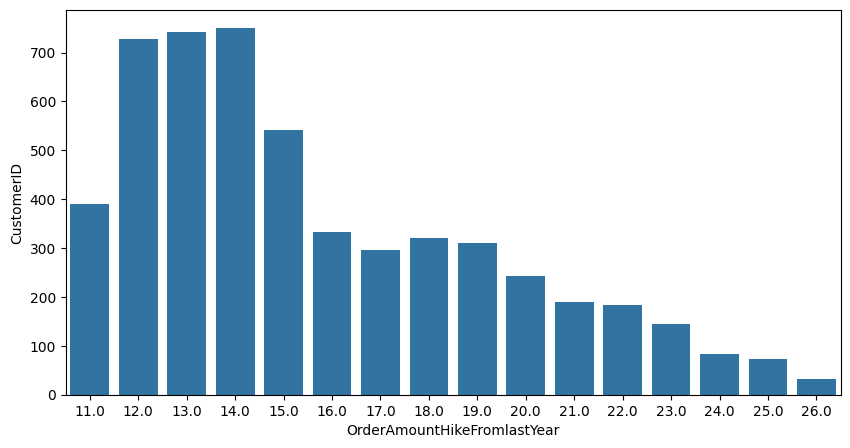

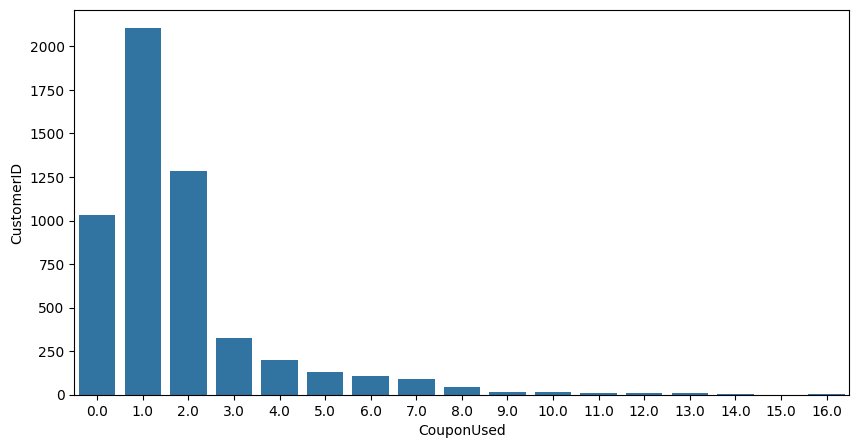

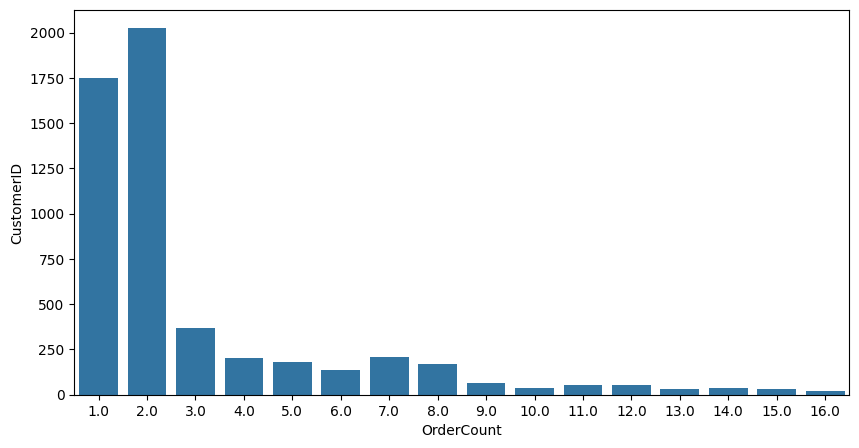

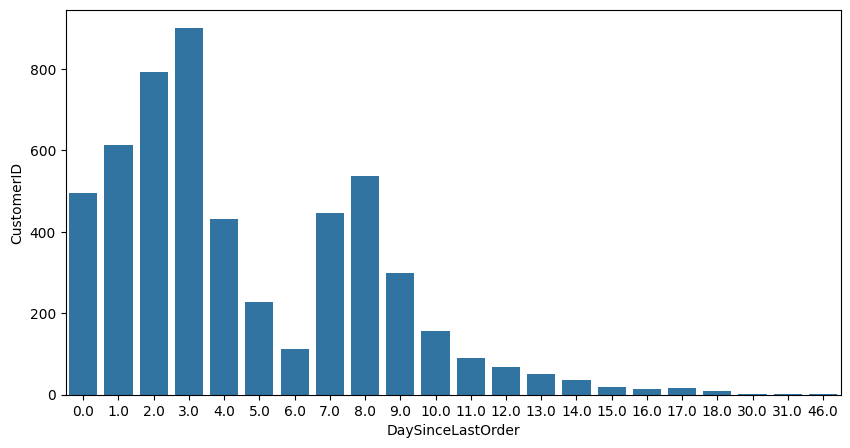

In [ ]:
#Check if there is any outlier in columns containning missing value
for i in list_null:
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_df = df.groupby(i)[['CustomerID']].count().reset_index()
    sns.barplot(data = plot_df,x=plot_df[i],y=plot_df['CustomerID'], ax=ax)
    plt.show()

**=> Based on the above distribution, missing values can be replace:**

+ With **median**: Tenure, WarehouseToHome, OrderAmountHikeFromlastYear, OrderCount, DaySinceLastOrder

+ With **0**: HourSpendOnApp, CouponUsed

<Axes: >

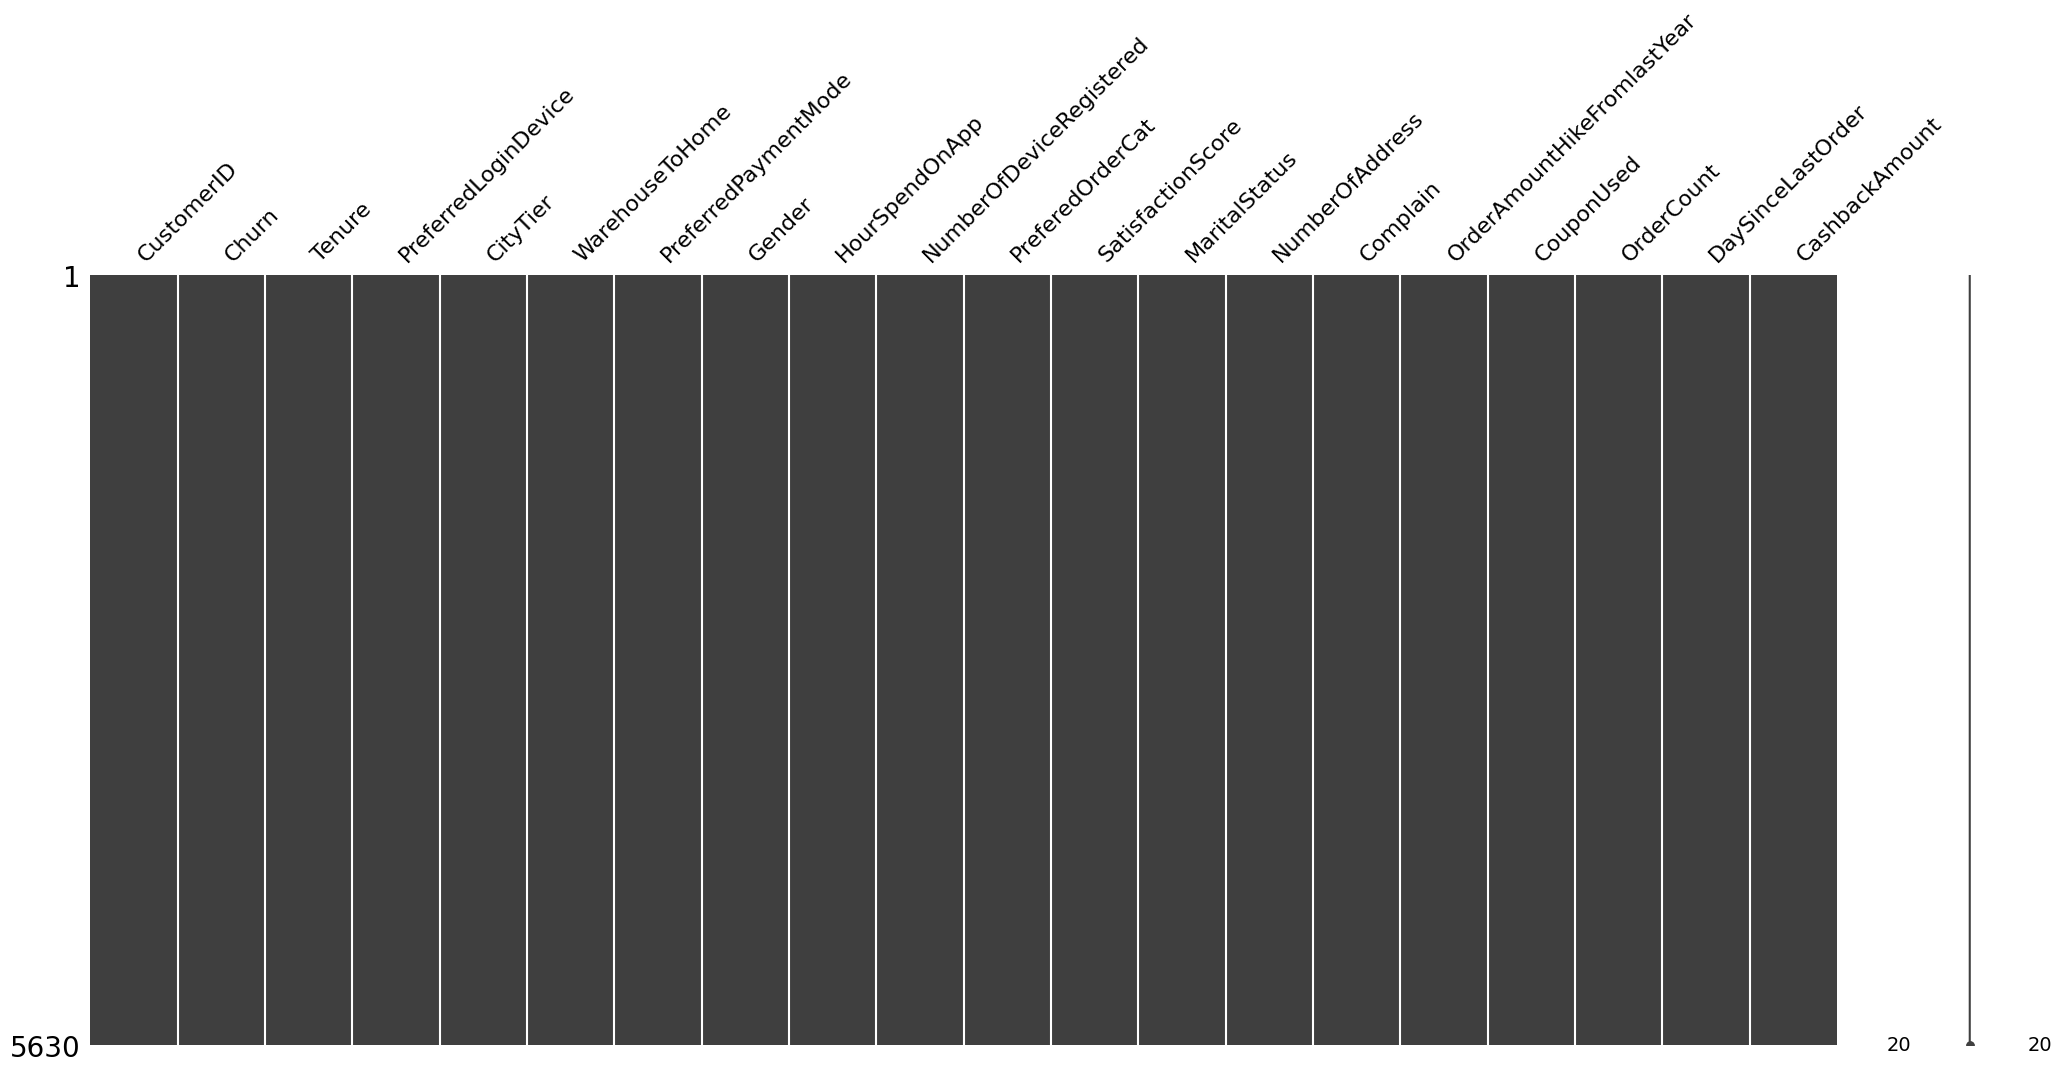

In [ ]:
#Replace missing values
def replace_func(list_columns):
  for i in list_columns:
    if i in ['Tenure', 'WarehouseToHome', 'OrderAmountHikeFromlastYear', 'OrderCount', 'DaySinceLastOrder']:
      median = df[i].median()
    df[i].fillna(median, inplace=True)
  else:
      df[i].fillna(0, inplace=True)

replace_func(list_null)
msno.matrix(df)

In [ ]:
 #Check if there is any duplicated value
 df.duplicated().any()

False

**1.3 EDA**

**1.3.1 Check correlation among numeric features**

<Axes: >

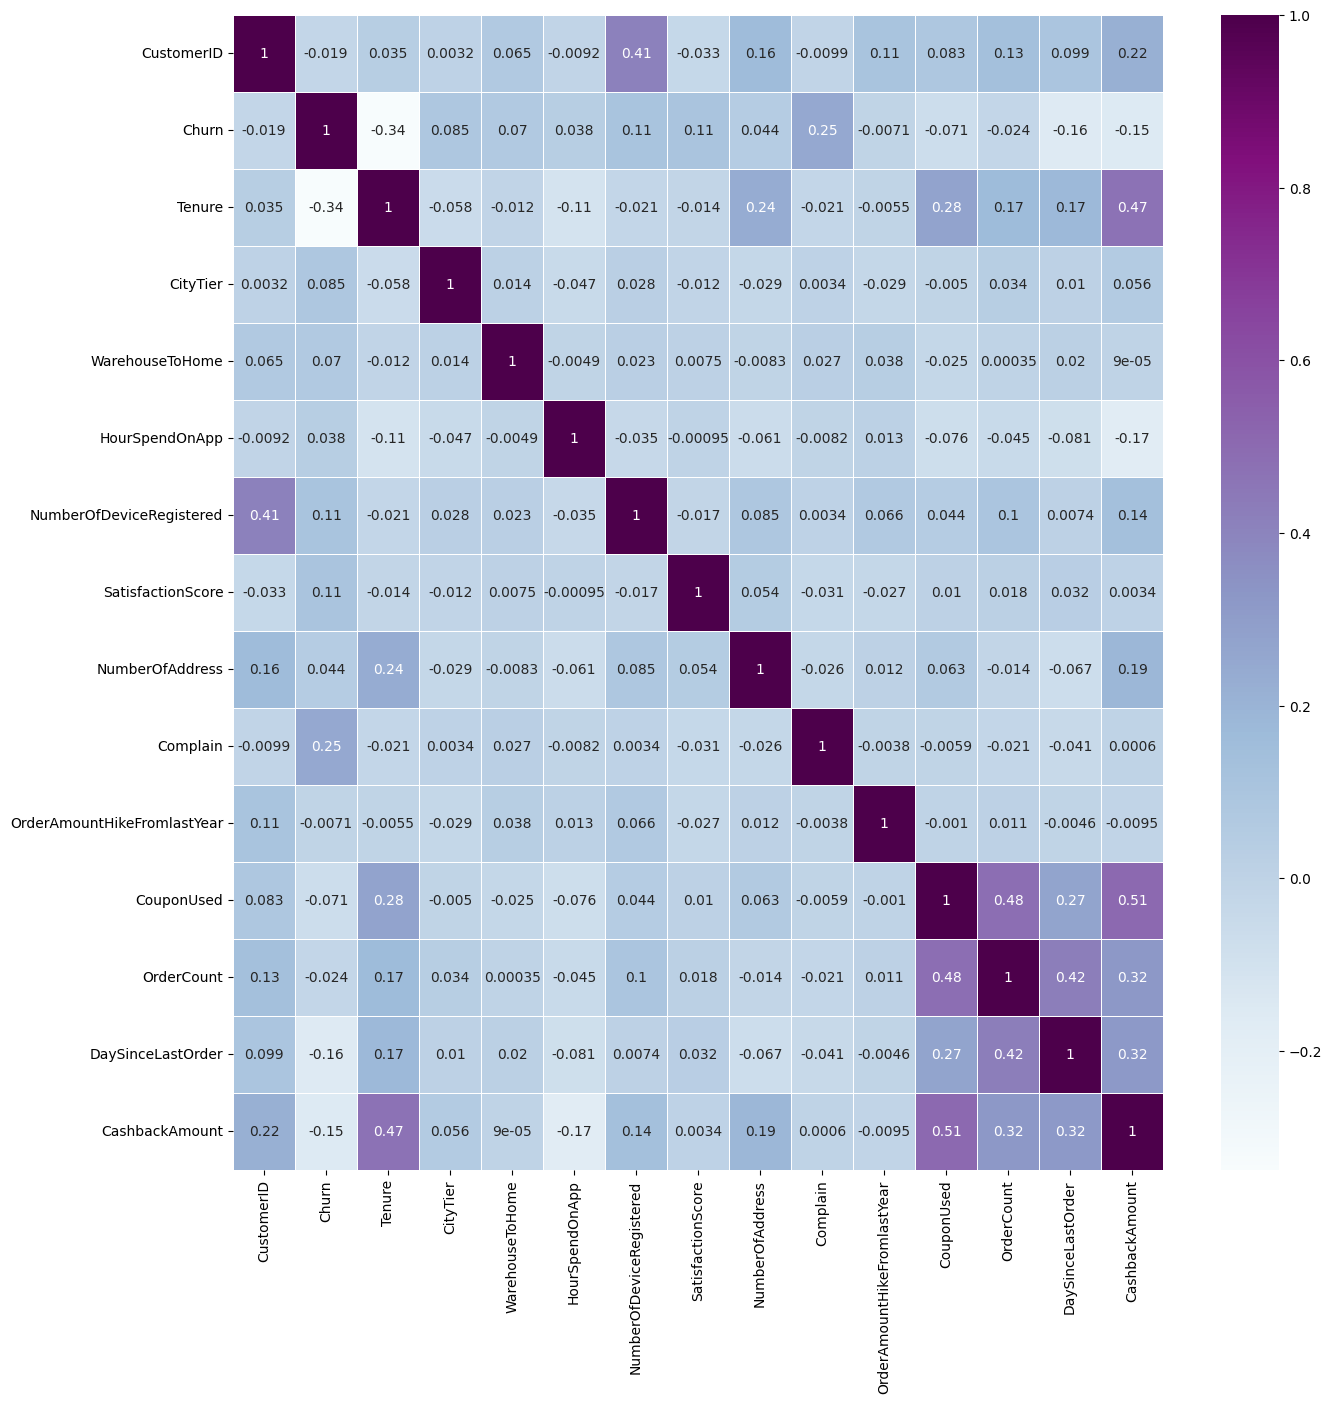

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), cmap="BuPu", annot=True, ax=ax, linewidth=.5)

**1.3.2 Calcualte the churned customers by tenure -> check the periods when customers mostly start to churn**

In [ ]:
#Get the churned cutomers by tenure
CustomerChurn = df.query('Churn==1')
ChurnedCusByTen = CustomerChurn[['Tenure', 'Churn']]
ChurnedCusByTen = ChurnedCusByTen.groupby('Tenure').count().reset_index()
#Get the total number of churned customer
ChurnedCusByTen['Total_churn'] = ChurnedCusByTen['Churn'].sum()
#Calculate the %churn of each tenure in the total custoomer churn
ChurnedCusByTen['%churn'] = ChurnedCusByTen['Churn']/ChurnedCusByTen['Total_churn']
ChurnedCusByTen

,Tenure,Churn,Total_churn,%churn
0,0.0,272,948,0.286920
1,1.0,349,948,0.368143
2,2.0,14,948,0.014768
3,3.0,18,948,0.018987
4,4.0,20,948,0.021097
5,5.0,16,948,0.016878
6,6.0,8,948,0.008439
7,7.0,16,948,0.016878
8,8.0,16,948,0.016878
9,9.0,93,948,0.098101


<Axes: xlabel='Tenure', ylabel='%churn'>

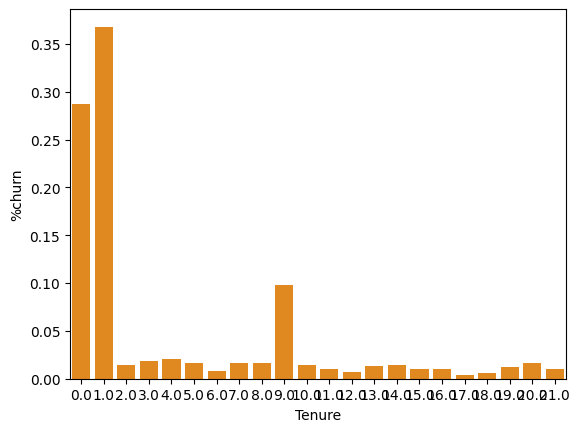

In [ ]:
#Visualize the churned customers by tenure
sns.barplot(data=ChurnedCusByTen, x='Tenure', y='%churn', color='darkorange')

**1.3.3 Calcualte the churned customers by category -> check the categories containing high number of churned customers**

In [ ]:
#Get the churned cutomers by category
CustomerChurn = df.query('Churn==1')
ChurnedCusByCat = CustomerChurn[['PreferedOrderCat', 'Churn']]
ChurnedCusByCat = ChurnedCusByCat.groupby('PreferedOrderCat').count().reset_index()
#Get the total number of churned customers
ChurnedCusByCat['Total_churn'] = ChurnedCusByCat['Churn'].sum()
#Calculate the %churn of each category in the total churned customers
ChurnedCusByCat['%churn'] = ChurnedCusByCat['Churn']/ChurnedCusByCat['Total_churn']
ChurnedCusByCat

,PreferedOrderCat,Churn,Total_churn,%churn
0,Fashion,128,948,0.135021
1,Grocery,20,948,0.021097
2,Laptop & Accessory,210,948,0.221519
3,Mobile,220,948,0.232068
4,Mobile Phone,350,948,0.369198
5,Others,20,948,0.021097


In [ ]:
#Get the total number of churned customers with complaints last month
CusComplain = df.query('Complain==1 and Churn==1')
#Combine the churned customers & customers with complaints last month
merge = CusComplain.merge(ChurnedCusByCat, on='PreferedOrderCat')
merge = merge[['PreferedOrderCat', 'Churn_x', 'Total_churn', '%churn', 'Complain']]
#Get the total numbers of complaints by category
TotalComplainByCat = merge[['PreferedOrderCat', 'Complain']]
TotalComplainByCat = TotalComplainByCat.groupby('PreferedOrderCat').count().reset_index()
#Get the total numbers of complaints
TotalComplainByCat['Total_complain'] = TotalComplainByCat['Complain'].sum()
#Get the % of complaints by category
TotalComplainByCat['%complain'] = TotalComplainByCat['Complain']/TotalComplainByCat['Total_complain']
#Combine churned customers & complaints by catergory
merge2 = ChurnedCusByCat.merge(TotalComplainByCat, on='PreferedOrderCat')
merge2 = merge2[['PreferedOrderCat', 'Churn', 'Total_churn', '%churn', '%complain']]
merge2

,PreferedOrderCat,Churn,Total_churn,%churn,%complain
0,Fashion,128,948,0.135021,0.102362
1,Grocery,20,948,0.021097,0.023622
2,Laptop & Accessory,210,948,0.221519,0.204724
3,Mobile,220,948,0.232068,0.263780
4,Mobile Phone,350,948,0.369198,0.381890
5,Others,20,948,0.021097,0.023622


<Axes: xlabel='PreferedOrderCat', ylabel='%churn'>

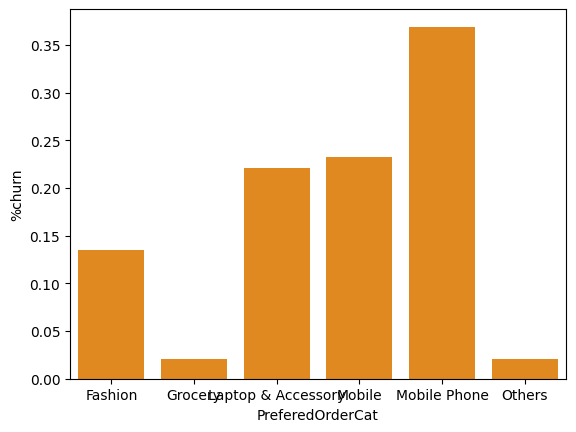

In [ ]:
#Visualize the churned customers by category
sns.barplot(data=ChurnedCusByCat, x='PreferedOrderCat', y='%churn', color='darkorange')

<Axes: xlabel='PreferedOrderCat', ylabel='%complain'>

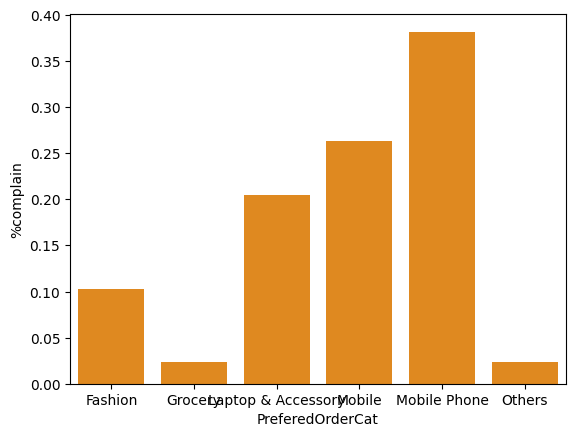

In [ ]:
#Visualize the churned customers by category with complaints
sns.barplot(data=merge2, x='PreferedOrderCat', y='%complain', color='darkorange')

**=> Some patterns/behavior of churned users can be seen after EDA:**
- Churned customers tend to stop using products/ service in tenure 0, 1 and 9.
- Most churned customers has the prefered product category 'Mobile Phone', 'Laptop & Accessory', 'Mobile' and 'Fashion'.
- Customers seem to be more unsatisfied with product category 'Mobile Phone', 'Laptop & Accessory', 'Mobile' and 'Fashion' than the others.

**=> Suggestions for company to reduce churned users:**
- Pay attention to the Tenure of customer in organization (when their tenures reach 0, 1, 9) --> take more actions to improve customer rentention by sending them some vouchers, discounts, .... for next orders.
- Focus on running marketing campaigns for some category ('Mobile Phone', 'Laptop & Accessory', 'Mobile' and 'Fashion') such as Buy 1 get 1, get discounts for next purchase,... --> reduce number of churned customers.
- Analyse the reasons behind customers' complaints (products/service/price/shipping problems/ etc) for category 'Mobile Phone', 'Laptop & Accessory', 'Mobile' and 'Fashion' to figure out proper solutions.
- Maintain customer satisfaction by giving them vouchers, gifts,... on holidays, birthdays,..and regularly survey customers about their satisfaction with products/services.

**2. Feature transforming**

In [ ]:
#Get the churned cutomers by tenure
df_new = df.merge(ChurnedCusByCat, on='PreferedOrderCat')
df_new = df_new.merge(merge2, on='PreferedOrderCat')
#Rename some columns for clearer meaning
df_new.rename(columns = {'Churn_y':'ChurnCusByCat'}, inplace = True)
df_new.rename(columns = {'Total_churn_x':'TotalChurnCus'}, inplace = True)
df_new.rename(columns = {'%churn_x':'%ChurnCusByCat'}, inplace = True)

df_new = df_new[['CustomerID', 'Churn_x', 'Tenure', 'WarehouseToHome', 'PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'ChurnCusByCat', 'TotalChurnCus', '%ChurnCusByCat', '%complain']]
df_new

,CustomerID,Churn_x,Tenure,WarehouseToHome,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,ChurnCusByCat,TotalChurnCus,%ChurnCusByCat,%complain
0,50001,1,4.0,6.0,Mobile Phone,3,Debit Card,Female,3.0,3,...,1,11.0,1.0,1.0,5.0,160,210,948,0.221519,0.204724
1,50004,1,0.0,15.0,Phone,3,Debit Card,Male,2.0,4,...,0,23.0,0.0,1.0,3.0,134,210,948,0.221519,0.204724
2,50007,1,9.0,11.0,Phone,3,Cash on Delivery,Male,2.0,3,...,0,14.0,0.0,1.0,0.0,121,210,948,0.221519,0.204724
3,50018,1,0.0,11.0,Mobile Phone,3,E wallet,Male,2.0,4,...,1,11.0,1.0,1.0,3.0,157,210,948,0.221519,0.204724
4,50019,1,0.0,13.0,Computer,1,Debit Card,Male,3.0,5,...,1,24.0,1.0,1.0,6.0,161,210,948,0.221519,0.204724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55512,0,22.0,29.0,Computer,1,Credit Card,Female,3.0,4,...,0,15.0,2.0,5.0,8.0,297,20,948,0.021097,0.023622
5626,55535,0,61.0,28.0,Mobile Phone,3,Debit Card,Female,4.0,4,...,1,15.0,1.0,2.0,1.0,304,20,948,0.021097,0.023622
5627,55564,0,13.0,22.0,Mobile Phone,3,E wallet,Male,4.0,4,...,0,13.0,5.0,2.0,11.0,258,20,948,0.021097,0.023622
5628,55606,0,15.0,35.0,Mobile Phone,1,Debit Card,Female,3.0,5,...,0,24.0,2.0,2.0,11.0,261,20,948,0.021097,0.023622


**2.1 Encoding**

In [ ]:
list_columns = ['PreferedOrderCat', 'PreferredPaymentMode', 'PreferredLoginDevice', 'Gender', 'MaritalStatus']
df_new = pd.get_dummies(df_new, columns = list_columns)
df_new


,CustomerID,Churn_x,Tenure,WarehouseToHome,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,50001,1,4.0,6.0,3,3.0,3,2,9,1,...,0,0,0,1,0,1,0,0,0,1
1,50004,1,0.0,15.0,3,2.0,4,5,8,0,...,0,0,0,0,1,0,1,0,0,1
2,50007,1,9.0,11.0,3,2.0,3,2,4,0,...,0,0,0,0,1,0,1,1,0,0
3,50018,1,0.0,11.0,3,2.0,4,3,2,1,...,1,0,0,1,0,0,1,0,0,1
4,50019,1,0.0,13.0,1,3.0,5,3,2,1,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55512,0,22.0,29.0,1,3.0,4,1,5,0,...,0,0,1,0,0,1,0,0,1,0
5626,55535,0,61.0,28.0,3,4.0,4,1,6,1,...,0,0,0,1,0,1,0,0,1,0
5627,55564,0,13.0,22.0,3,4.0,4,5,2,0,...,1,0,0,1,0,0,1,0,0,1
5628,55606,0,15.0,35.0,1,3.0,5,4,2,0,...,0,0,0,1,0,1,0,0,1,0


**2.2 Normalizing**

In [ ]:
list_columns = df_new.columns.tolist()

from sklearn.preprocessing import MinMaxScaler

filter_df = df_new[list_columns]
scaler = MinMaxScaler()
model=scaler.fit(filter_df)
scaled_data=model.transform(filter_df)

df_new = pd.DataFrame(scaled_data, columns = list_columns)
df_new

,CustomerID,Churn_x,Tenure,WarehouseToHome,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.000000,1.0,0.065574,0.008197,1.0,0.214286,0.4,0.25,0.380952,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000533,1.0,0.000000,0.081967,1.0,0.142857,0.6,1.00,0.333333,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.001066,1.0,0.147541,0.049180,1.0,0.142857,0.4,0.25,0.142857,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.003020,1.0,0.000000,0.049180,1.0,0.142857,0.6,0.50,0.047619,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.003198,1.0,0.000000,0.065574,0.0,0.214286,0.8,0.50,0.047619,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0.979037,0.0,0.360656,0.196721,0.0,0.214286,0.6,0.00,0.190476,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5626,0.983123,0.0,1.000000,0.188525,1.0,0.285714,0.6,0.00,0.238095,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5627,0.988275,0.0,0.213115,0.139344,1.0,0.285714,0.6,1.00,0.047619,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5628,0.995736,0.0,0.245902,0.245902,0.0,0.214286,0.8,0.75,0.047619,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


**3. Model selection & Model evaluation**

**3.1 Apply model: Logistics Regression**

In [ ]:
from sklearn.model_selection import train_test_split

#Exclude target column
x=df_new.drop('Churn_x', axis = 1)
y=df_new[['Churn_x']]
#Split data into train & test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#Apply Logistics regression
from sklearn.linear_model import LogisticRegression
#Instantiate the model
logreg = LogisticRegression()
#Fit the model on training data
logreg.fit(x_train, y_train)


LogisticRegression()

In [ ]:
#Predict on train set
y_pred_train = logreg.predict(x_train)
#Predict on test set
y_pred_test = logreg.predict(x_test)

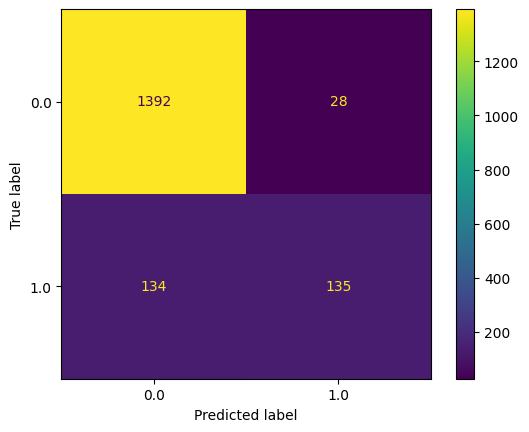

In [ ]:
#Show confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
#Calculate balanced accuracy of the model
from sklearn.metrics import balanced_accuracy_score

print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_pred_train)}'),
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred_test)}')

Balance accuracy of train set: 0.7159844381095654
Balance accuracy of test set: 0.7410702131001623


**=> The balanced accuracy shows that there is no overfitting/ underfitting**

**3.2 Apply model: Decision Tree**

In [ ]:
#Apply Decision Tree
from sklearn import tree
#Instantiate the model
dectree = tree.DecisionTreeClassifier()
#Fit the model on training data
dectree.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
#Predict on train set
y_tree_pred_train = dectree.predict(x_train)
#Predict on test set
y_tree_pred_test = dectree.predict(x_test)

In [ ]:
#Calculate balanced accuracy of the model
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pred_train)}'),
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pred_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.8749803654641604


**=> There can be overfitting in decision tree model**

**3.3 Apply model: Random Forest**

In [ ]:
#Apply Random Forest
from sklearn.ensemble import RandomForestClassifier
#Instantiate the model
ranforest = RandomForestClassifier(max_depth=2, random_state=0)
#Fit the model on training data
ranforest.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
#Predict on train set
y_ranf_pred_train = ranforest.predict(x_train)
#Predict on test set
y_ranf_pred_test = ranforest.predict(x_test)

In [ ]:
#Calculate balanced accuracy of the model
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_pred_train)}'),
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_pred_test)}')

Balance accuracy of train set: 0.5
Balance accuracy of test set: 0.5


**=> The model doesn't capture any significant patterns from the data**

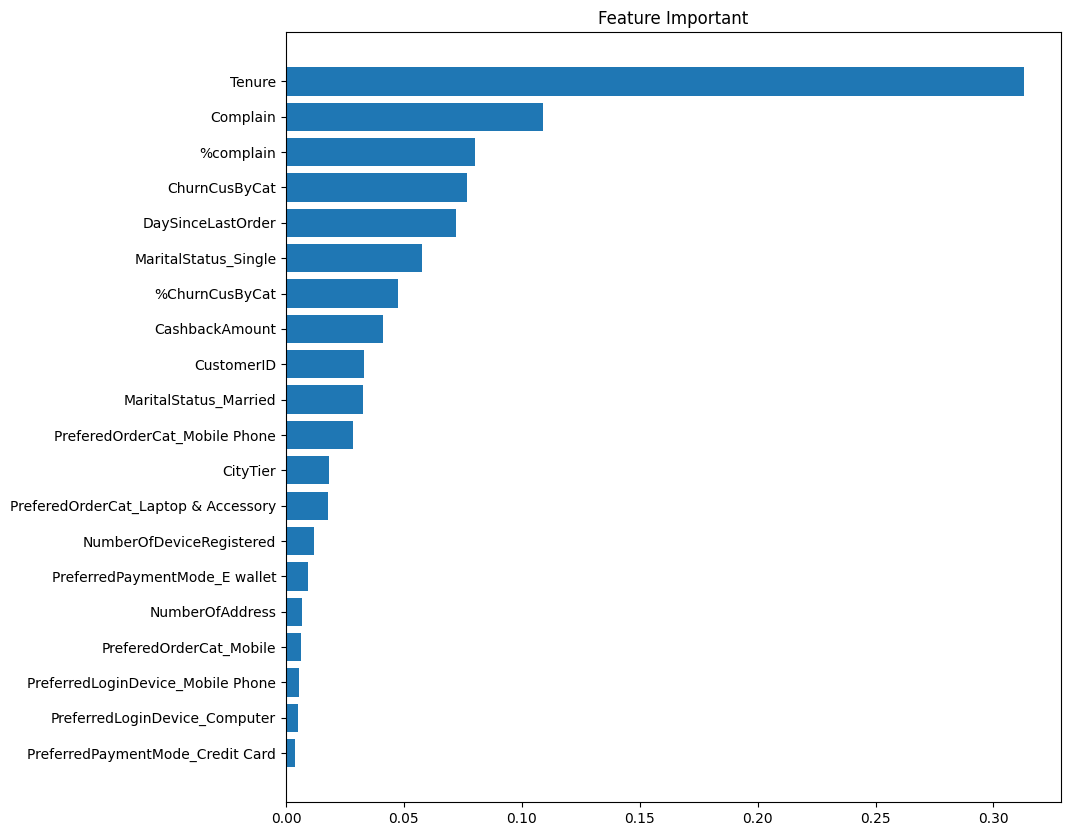

In [ ]:
#Show the feature important of random forest model
feats = {}
for feature, importance in zip(x_test.columns, ranforest.feature_importances_):
    feats[feature] = importance #add the name/value pair
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances = importances.sort_values(by='Gini-importance', ascending=True)
    importances = importances.reset_index()
#Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')
#Show plot
plt.show()

**=> Tenure, Complain and %Complain have the highest feature importance, which corresponds with the EDA conclusion.**

**4. Model performance improvement**

**4.1 Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
#Input the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
#Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(ranforest, param_grid, cv=5, scoring='balanced_accuracy')
#Fit the model
grid_search.fit(x_train, y_train)

#Print the best parameters
print("Best Parameters: ", grid_search.best_params_)
#Evaluate the best model on the test set
best_ran = grid_search.best_estimator_
accuracy = best_ran.score(x_test, y_test)
print("Test set accuracy: ", accuracy)

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test set accuracy:  0.9727649496743636


In [ ]:
#Apply the best parameters to the model
from sklearn import tree

ranf_bestpara = RandomForestClassifier(
n_estimators= 200,
max_depth= 20,
min_samples_split = 2,
min_samples_leaf = 1,
bootstrap= False)

ranf_bestpara.fit(x_train,y_train)


RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=200)

In [ ]:
y_ranf_bestpara_train = ranf_bestpara.predict(x_train)
y_ranf_bestpara_test = ranf_bestpara.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_bestpara_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_bestpara_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9246923922718466


In [ ]:
y_randf_bestpara_proba = ranf_bestpara.predict_proba(x_test)[:,1]
y_randf_bestpara_proba

array([0.11 , 0.05 , 0.025, ..., 0.01 , 0.57 , 0.   ])

**4.2 Probability Threshold Selection**

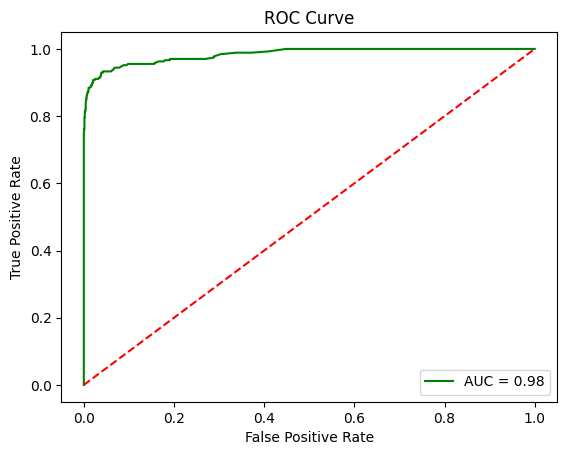

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_randf_bestpara_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='green', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Calculate the distance for each threshold
distances = np.sqrt((0 - fpr)**2 + (1 - tpr)**2),
#Get the threshold for the smallest distance
best_threshold = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.245


In [ ]:
#Re-apply new threshold for model after apply new hyperparameter
threshold = 0.245
y_rand_tun_proba = ranf_bestpara.predict_proba(x_test)[:,1]
y_pred_prod = (y_rand_tun_proba > threshold).astype(int)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_prod)
print("Test balanced accurary :", round(balanced_accuracy,5))

Test balanced accurary : 0.94356


**=> Based on test balanced accuracy of Hyperparameter tuning & Probability threshold selection, the Random Forest model with the following parameters can be chosen:**

n_estimators= 200,

max_depth= 20,

min_samples_split = 2,

min_samples_leaf = 1,

bootstrap= False